In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import fpmax
import itertools
import copy
import numpy as np
from scipy.stats import stats
import random
import pickle

import os
import sys

# Preprocess Data
   * Identifiers starting with "BA" indicate sensor battery levels - (0-100)
   * Identifiers starting with "D" indicate magnetic door sensors - (open/close)
   * Identifiers starting with "L" and "LL" indicate light switches - (on/off)
   * Identifiers starting with "LS" indicate light sensors - numeric
   * Identifiers starting with "M" indicate infrared motion sensors - binary
   * Identifiers starting with "MA" indicate wide-area infrared motion sensors - bin
   * Identifiers starting with "T" indicate temperature sensors - numeric

In [3]:
raw_data = './hh102/rawdata.txt'
pickle_data='./hh102/rawdata.pkl'
unique_value='./hh102/unique_device_value.pkl'

In [4]:
def make_data():
    df = pd.read_table(raw_data, delim_whitespace=True, names=('Time', 'Device', 'Value'))
    return df

In [5]:
def is_binary_device_by_df(df):
    if (df['Device'][0:1] == 'M' 
        or df['Device'][0:1] == 'D' 
        or df['Device'][0:2] == 'L0'):
        val = bool(True)
    else:
        val = bool(False)
    return val

In [6]:
df = make_data()
df['binary_device'] = df.apply(is_binary_device_by_df, axis=1)
df.to_pickle(pickle_data)


In [10]:
df = pd.read_pickle(pickle_data)
df.head(30)



,Time,Device,Value,binary_device
2011-06-13,12:29:06.215521,M012,OFF,True
2011-06-13,12:29:06.26804,M005,OFF,True
2011-06-13,12:29:06.3225,M011,OFF,True
2011-06-13,12:29:06.375079,LS012,17,False
2011-06-13,12:29:06.41612,BATP012,100,False
2011-06-13,12:29:06.492345,BATV012,9580,False
2011-06-13,12:29:06.535376,D006,CLOSE,True
2011-06-13,12:29:06.723627,D005,CLOSE,True
2011-06-13,12:29:06.767742,MA009,OFF,True
2011-06-13,12:29:06.81956,LS010,35,False


In [18]:
df1 = df.groupby('Device').nunique()
df1


,Time,Value,binary_device
Device,,,
BATP001,1902,69,1
BATP002,1821,84,1
BATP003,1750,92,1
BATP004,1991,90,1
BATP005,1940,87,1
...,...,...,...
T101,2547,14,1
T102,2482,8,1
T103,4252,9,1


In [58]:
df2 = df.groupby('Device').apply(lambda x: x['Value'].unique())

In [59]:
df3 = df2.to_frame().reset_index()
df3.columns = ['Device', 'Values']
df3

,Device,Values
0,BATP001,"[100, 99, 98, 94, 93, 92, 91, 90, 89, 88, 87, ..."
1,BATP002,"[100, 99, 98, 94, 95, 93, 92, 91, 90, 89, 88, ..."
2,BATP003,"[100, 99, 98, 97, 96, 94, 93, 95, 92, 91, 90, ..."
3,BATP004,"[100, 99, 98, 97, 96, 93, 95, 94, 92, 91, 90, ..."
4,BATP005,"[100, 99, 98, 97, 96, 95, 94, 93, 0, 92, 91, 9..."
...,...,...
122,T101,"[29, 30, 31, 32, 33, 34, 35, 36, 25, 26, 27, 2..."
123,T102,"[26, 25, 27, 24, 23, 22, 21, 28]"
124,T103,"[28, 27, 26, 25, 24, 23, 22, 29, 21]"
125,T104,"[29, 28, 27, 26, 25, 24, 23, 22, 21]"


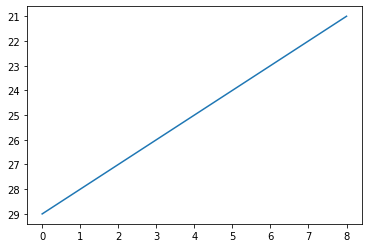

In [49]:
# Nhiet Do
plt.plot(df3['Values'].iloc[125])
plt.show()

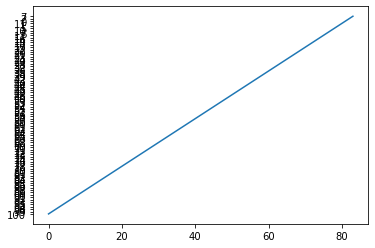

In [60]:
# Battery
plt.plot(df3['Values'].iloc[1])
plt.show()